In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import requests as rq
from tqdm.auto import tqdm

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO, SeqIO
from Bio.Align.Applications import ClustalwCommandline

In [2]:
uniprot = pd.read_csv('seqs/csv/uniprot-filtered-reviewed_yes.tab', sep='\t', index_col=0).drop_duplicates('Sequence')
uniprot = uniprot[~uniprot['Domain [FT]'].isna()].copy()
uniprot = uniprot[uniprot['Domain [FT]'].str.lower().str.contains('upar')].copy()
uniprot

,Entry name,Protein names,Gene names,Organism,Length,Domain [FT],Sequence
Entry,,,,,,,
P0DP61,SLUR2_MACMU,Secreted Ly-6/uPAR domain-containing protein 2,SLURP2,Macaca mulatta (Rhesus macaque),97,"DOMAIN 23..95; /note=""UPAR/Ly6""",MQFHTGLLLAAVLSLQLAAAQALWCHQCTGFGGCSRGSRCPRDSTH...
P55000,SLUR1_HUMAN,Secreted Ly-6/uPAR-related protein 1 (SLURP-1)...,SLURP1 ARS,Homo sapiens (Human),103,"DOMAIN 24..73; /note=""UPAR/Ly6""",MASRWAVQLLLVAAWSMGCGEALKCYTCKEPMTSASCRTITRCKPE...
P83107,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1 (Protein BOP1),SOLD1 BOP1,Bos taurus (Bovine),100,"DOMAIN 23..100; /note=""UPAR/Ly6""; /evidence=...",MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...
P0DP57,SLUR2_HUMAN,Secreted Ly-6/uPAR domain-containing protein 2...,SLURP2,Homo sapiens (Human),97,"DOMAIN 25..95; /note=""UPAR/Ly6""; /evidence=""...",MQLGTGLLLAAVLSLQLAAAEAIWCHQCTGFGGCSHGSRCLRDSTH...
D3YWX3,PAT13_MOUSE,Prostate and testis expressed protein 13 (Pros...,Pate13 Gm3867 Pate-X,Mus musculus (Mouse),137,"DOMAIN 28..114; /note=""UPAR/Ly6""; /evidence=...",MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...
...,...,...,...,...,...,...,...
Q9GK80,UPAR_PANTR,Urokinase plasminogen activator surface recept...,PLAUR UPAR,Pan troglodytes (Chimpanzee),335,"DOMAIN 23..114; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGHPPLLPLLLLLHTCVPASWGLRCMQCKTNGDCRVEECALGQDLC...
P35456,UPAR_MOUSE,Urokinase plasminogen activator surface recept...,Plaur,Mus musculus (Mouse),327,"DOMAIN 24..117; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGLPRRLLLLLLLATTCVPASQGLQCMQCESNQSCLVEECALGQDL...
P57096,PSCA_MOUSE,Prostate stem cell antigen,Psca,Mus musculus (Mouse),123,"DOMAIN 21..95; /note=""UPAR/Ly6""",MKTVFFLLLATYLALHPGAALQCYSCTAQMNNRDCLNVQNCSLDQH...


In [3]:
known_upars = set(pd.read_csv('seqs/csv/acess_upar.txt', squeeze=True)) | set(uniprot.index)
len(known_upars)

198

In [4]:
def retrieve_uniprot_data_by_acess(acess):
    """
    Retrieve protein by ID from UniProt
    """
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{acess}"
#     print(requestURL)
    r = rq.get(requestURL, headers={"Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        return 0
    responseBody = r.json()

    try:
        features = responseBody['features']
    except KeyError:
        type_ = None
        start, end = np.nan, np.nan
    else:
        st_nd = [(start := i['begin'], end := i['end']) for i in features if i.get('description') and i['description'] == 'UPAR/Ly6']
        type_ = 'DOMAIN'
        if not st_nd:
            type_ = 'CHAIN'
            st_nd = [(start := i['begin'], end := i['end']) for i in features if i['type'] == 'CHAIN'] 

    try:
        prot_name = responseBody['protein']['submittedName'][0]['fullName']['value']

    except:
        prot_name = responseBody['protein']['recommendedName']['fullName']['value']
    
    return {'sequence': responseBody['sequence']['sequence'],
            'id': responseBody['id'],
            'protein_name': prot_name,
            'org': responseBody['organism']['names'][0]['value'],
            'start': start,
            'end': end,
            'type_': type_,
            'acess': acess}

In [5]:
res = pd.DataFrame()
for acess in tqdm(known_upars):
    tmp = retrieve_uniprot_data_by_acess(acess)
    if tmp:
        res = res.append(tmp, ignore_index=True)
    else:
        print('!!!!!!!!!!!!!!!')
        break
res = res.drop_duplicates('sequence')

short = res[res.sequence.str.len() < 190].copy()
short = short.fillna(-1)
short.start, short.end = short.start.astype(np.int32), short.end.astype(np.int32)

long = res[res.sequence.str.len() > 190].copy()

  0%|          | 0/198 [00:00<?, ?it/s]

In [6]:
res.shape[0] == res.drop_duplicates('id').shape[0]

True

In [7]:
print(long.shape, short.shape)
res

(44, 8) (153, 8)


,sequence,id,protein_name,org,start,end,type_,acess
0,MTSRGVHLLLRLLFLLAVFYSSDSSLMCYHCLLPSPNCSTVTNCTP...,CD59_RABIT,CD59 glycoprotein,Oryctolagus cuniculus,25,101,DOMAIN,O77541
1,MRARVLVGMLTMVGFAMGKAPVARVRTCHLCLLEDPSLGCISGSEK...,LY65B_MOUSE,Lymphocyte antigen 6 complex locus protein G5b,Mus musculus,26,118,DOMAIN,Q8K1T4
2,MKVLGICVILTLIFNGINCIKNKKVKCYRCSDCPNPFDKTQITELG...,B8Y6H3_SCHMA,DIF_5,Schistosoma mansoni,20,124,CHAIN,B8Y6H3
3,MGHPPLLPLLLLLHTCVPASWGLRCMQCKTNGDCRVEECALGQDLC...,UPAR_HUMAN,Urokinase plasminogen activator surface receptor,Homo sapiens,23,305,CHAIN,Q03405
4,MNKHFLFLFLLYCLIVAVTSLQCITCHLRTRTDRCRRGFGVCTAQK...,PATE3_HUMAN,Prostate and testis expressed protein 3,Homo sapiens,21,97,DOMAIN,B3GLJ2
...,...,...,...,...,...,...,...,...
193,MKTVLLFLVALAAAAGPAQALRCHVCTSSSNCKKPQVCSASSSFCK...,LY6D_BOVIN,Lymphocyte antigen 6D,Bos taurus,21,108,DOMAIN,Q148C3
194,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,3SLS_DENPO,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947
195,MKSCGLIIIALLLLSSNAAHAVDCYKCDYGACLFPTVKSCSFGEVC...,A0A1L8F8M0_XENLA,Tfp3,Xenopus laevis,22,122,CHAIN,A0A1L8F8M0
196,MTAPWVALALLWGSLCAGSGRGEAETRECIYYNANWELERTNQSGL...,AVR2B_HUMAN,Activin receptor type-2B,Homo sapiens,19,512,CHAIN,Q13705


In [8]:
def get_domain(x):
    if hasattr(x, 'start'):
        n_st = x.start - 6
    else:
        n_st = 0
    n_end = len(x.sequence)
    result = []
    for st, en in itertools.product(np.arange(n_st, n_end - 20), np.arange(n_st + 20, n_end + 1)):
        if len((string := x.sequence[st: en])) > 45:
            if 'CN' == string[-2:] and string[2] == 'C' and string.count('C') % 2 == 0 and string.count('C') >= 8 and string.count('C') <= 12 and len(string) < 100:
                result.append(string)
            
    return max(result, key=lambda x: len(x)) if result else np.nan

In [9]:
short['domain'] = short.apply(get_domain, axis=1)
short = short.drop_duplicates('sequence')
inds = short[short.domain.isna()].index
print(inds)
for i in inds:
    short.loc[i, 'domain'] = short.loc[i, 'sequence'][short.loc[i, 'start']: short.loc[i, 'end']]
short

Int64Index([91], dtype='int64')


,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTSRGVHLLLRLLFLLAVFYSSDSSLMCYHCLLPSPNCSTVTNCTP...,CD59_RABIT,CD59 glycoprotein,Oryctolagus cuniculus,25,101,DOMAIN,O77541,LMCYHCLLPSPNCSTVTNCTPNHDACLTAVSGPRVYRQCWRYEDCN...
2,MKVLGICVILTLIFNGINCIKNKKVKCYRCSDCPNPFDKTQITELG...,B8Y6H3_SCHMA,DIF_5,Schistosoma mansoni,20,124,CHAIN,B8Y6H3,VKCYRCSDCPNPFDKTQITELGNCNFCRTVYTYRDEDNYRIAKDCV...
4,MNKHFLFLFLLYCLIVAVTSLQCITCHLRTRTDRCRRGFGVCTAQK...,PATE3_HUMAN,Prostate and testis expressed protein 3,Homo sapiens,21,97,DOMAIN,B3GLJ2,LQCITCHLRTRTDRCRRGFGVCTAQKGEACMLLRIYQRNTLQISYM...
5,TMCYSHTTTSRAILTNCGENSCYRKSRRHPPKMVLGRGCGCPPGDD...,3SE1_DENAN,Fasciculin-1,Dendroaspis angusticeps,1,61,CHAIN,P0C1Y9,TMCYSHTTTSRAILTNCGENSCYRKSRRHPPKMVLGRGCGCPPGDD...
7,LTCKTCPFTTCPNSESCPGGQSICYQRKWEEHHGERIERRCVANCP...,3NX2_MICMP,Micrurotoxin 2,Micrurus mipartitus,1,64,CHAIN,C0HJR2,LTCKTCPFTTCPNSESCPGGQSICYQRKWEEHHGERIERRCVANCP...
...,...,...,...,...,...,...,...,...,...
192,MRALLLLSLSALLCWVSADIRCHSCYKLPVLGCVDRKSCRLEPGQQ...,LY66C_BOVIN,Lymphocyte antigen 6 complex locus protein G6c,Bos taurus,20,111,DOMAIN,A0JNL5,IRCHSCYKLPVLGCVDRKSCRLEPGQQCLTTHAYIGKMWVFSRLDC...
193,MKTVLLFLVALAAAAGPAQALRCHVCTSSSNCKKPQVCSASSSFCK...,LY6D_BOVIN,Lymphocyte antigen 6D,Bos taurus,21,108,DOMAIN,Q148C3,LRCHVCTSSSNCKKPQVCSASSSFCKTVIRVEPLSGNLVEKNCSVW...
194,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,3SLS_DENPO,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...
195,MKSCGLIIIALLLLSSNAAHAVDCYKCDYGACLFPTVKSCSFGEVC...,A0A1L8F8M0_XENLA,Tfp3,Xenopus laevis,22,122,CHAIN,A0A1L8F8M0,VDCYKCDYGACLFPTVKSCSFGEVCMTQTASTSSLPITVHKRDCLS...


In [10]:
# tmp_copy = short.copy()
# short = tmp_copy.copy()

In [11]:
lab = pd.read_csv('seqs/csv/Short_len_upar.csv', index_col=0)
lab.Prot = lab.Prot.str.replace(' ', '_').str.upper()
lab = lab.Prot.to_dict()

def rename_for_lab(series: pd.Series):
    lab_name = lab.get(series.acess)
    if lab_name:
        series.id = lab_name + '_' + series.id.split('_')[1]
    return series

In [12]:
short = short.apply(rename_for_lab, axis=1)
short.id = short.id.str.rsplit('_', 1).str[0] + '_|_' + short.org.str.replace(' ', '_')
short.to_csv('seqs/csv/short_upar_all_data.csv', index=None)
short

,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTSRGVHLLLRLLFLLAVFYSSDSSLMCYHCLLPSPNCSTVTNCTP...,CD59_|_Oryctolagus_cuniculus,CD59 glycoprotein,Oryctolagus cuniculus,25,101,DOMAIN,O77541,LMCYHCLLPSPNCSTVTNCTPNHDACLTAVSGPRVYRQCWRYEDCN...
2,MKVLGICVILTLIFNGINCIKNKKVKCYRCSDCPNPFDKTQITELG...,SMP105220_|_Schistosoma_mansoni,DIF_5,Schistosoma mansoni,20,124,CHAIN,B8Y6H3,VKCYRCSDCPNPFDKTQITELGNCNFCRTVYTYRDEDNYRIAKDCV...
4,MNKHFLFLFLLYCLIVAVTSLQCITCHLRTRTDRCRRGFGVCTAQK...,PATE3_|_Homo_sapiens,Prostate and testis expressed protein 3,Homo sapiens,21,97,DOMAIN,B3GLJ2,LQCITCHLRTRTDRCRRGFGVCTAQKGEACMLLRIYQRNTLQISYM...
5,TMCYSHTTTSRAILTNCGENSCYRKSRRHPPKMVLGRGCGCPPGDD...,FASCICULIN_1_|_Dendroaspis_angusticeps,Fasciculin-1,Dendroaspis angusticeps,1,61,CHAIN,P0C1Y9,TMCYSHTTTSRAILTNCGENSCYRKSRRHPPKMVLGRGCGCPPGDD...
7,LTCKTCPFTTCPNSESCPGGQSICYQRKWEEHHGERIERRCVANCP...,MICRUROTOXIN_2_|_Micrurus_mipartitus,Micrurotoxin 2,Micrurus mipartitus,1,64,CHAIN,C0HJR2,LTCKTCPFTTCPNSESCPGGQSICYQRKWEEHHGERIERRCVANCP...
...,...,...,...,...,...,...,...,...,...
192,MRALLLLSLSALLCWVSADIRCHSCYKLPVLGCVDRKSCRLEPGQQ...,LY66C_|_Bos_taurus,Lymphocyte antigen 6 complex locus protein G6c,Bos taurus,20,111,DOMAIN,A0JNL5,IRCHSCYKLPVLGCVDRKSCRLEPGQQCLTTHAYIGKMWVFSRLDC...
193,MKTVLLFLVALAAAAGPAQALRCHVCTSSSNCKKPQVCSASSSFCK...,LY6D_|_Bos_taurus,Lymphocyte antigen 6D,Bos taurus,21,108,DOMAIN,Q148C3,LRCHVCTSSSNCKKPQVCSASSSFCKTVIRVEPLSGNLVEKNCSVW...
194,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,CALCISEPTINE_|_Dendroaspis_polylepis_polylepis,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...
195,MKSCGLIIIALLLLSSNAAHAVDCYKCDYGACLFPTVKSCSFGEVC...,TFP3_|_Xenopus_laevis,Tfp3,Xenopus laevis,22,122,CHAIN,A0A1L8F8M0,VDCYKCDYGACLFPTVKSCSFGEVCMTQTASTSSLPITVHKRDCLS...


In [13]:
short[short.id == 'TFP5_|_ Xenopus laevis']

,sequence,id,protein_name,org,start,end,type_,acess,domain


In [14]:
def save_df_to_fasta(df, filename, seq_col='sequence', org='org', protein_name='protein_name'):
    req_list = []
    for ind, row in df.iterrows():
        req_list.append(SeqRecord(seq=Seq(row[seq_col]),
                                  id=row.id,
                                  name=row[protein_name],
                                  description='| ' + row[protein_name] + ' | ' + row[org]
                                 ))
    with open(filename, 'w') as f:
        SeqIO.write(req_list, f, 'fasta')

In [15]:
save_df_to_fasta(short, 'blast/blastdb/short_ly_domain_db.fs', seq_col='domain')

In [16]:
%%bash -s 'short_ly_domain_db.fs'
cd 'blast/blastdb/'
makeblastdb -in "$1" -dbtype prot



Building a new DB, current time: 11/24/2021 21:03:10
New DB name:   /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
New DB title:  short_ly_domain_db.fs
Sequence type: Protein
Deleted existing Protein BLAST database named /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 153 sequences in 0.00473404 seconds.


In [17]:
%%bash -s 'blastdb/short_ly_domain_db.fs' 'aplanci_blast_short.txt' 'arubens_blast_short.txt'
cd 'blast'
blastp -db "$1" -query "../seqs/aplanci_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$2"
blastp -db "$1" -query "../seqs/arubens_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$3"
ls

aplanci_blast_short.txt
arubens_blast_short.txt
blastdb


In [18]:
def read_blast(name, org):
    df = pd.read_csv(f'seqs/csv/{name}', index_col=0)
    bl_name = name.split('_', 1)[0]
    bl = pd.read_csv(f'blast/{bl_name}_blast_short.txt', index_col=0, sep='\t', header=None).index.unique().tolist()
    df = df.loc[bl].reset_index()
    df['org'] = org
    df['genes'] = df.genes + '_|_' + df.org.str.replace(' ', '_')
    df['domain'] = df.apply(get_domain, axis=1)
    return df.drop_duplicates('domain').set_index('genes')
# [df.sequence.str.len() < 190]

In [19]:
aru = read_blast('arubens_seq.csv', 'Asterias rubens')
apl = read_blast('aplanci_seq.csv', 'Acanthaster planci')
print(aru.shape[0], apl.shape[0])

5 7


In [20]:
aru

,sequence,gene_len,org,domain
genes,,,,
XP_033628517.1_|_Asterias_rubens,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,Asterias rubens,LQCFTCEAEDTNENCNIKEAPVLKTCTSRQDRCLTQVIYSTERGKL...
XP_033635706.1_|_Asterias_rubens,MLMSNQHQCSMYSLRLLLLVVAIMYDATLVMGQTACSVADPVCRCT...,1123,Asterias rubens,AQCYTPESVQRQTIREAPFCIPVQRCYFCDQASTNGACNFATQLCS...
XP_033638913.1_|_Asterias_rubens,MNTLATIVVLMSLIAGMSALTCNTCGWITGVSDESCLDEFDATASN...,126,Asterias rubens,LTCNTCGWITGVSDESCLDEFDATASNSSVTCASGYDMCSKSTTKV...
XP_033640057.1_|_Asterias_rubens,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,Asterias rubens,IKCFTCTDKKSNRECNERAYDAFCPKGTKYCYSSHYLNQKSGESIL...
XP_033644501.1_|_Asterias_rubens,METNPSSQRLVVWMFIFAATIYFAQGNLRCYDCDVDFKTMSNPDLN...,152,Asterias rubens,LRCYDCDVDFKTMSNPDLNCIHNVINSTGDVMYEPRDCQPHERFCK...


In [21]:
apl

,sequence,gene_len,org,domain
genes,,,,
XP_022086630.1_|_Acanthaster_planci,MKMHPINLIFSLVGNVVGLECFDCVDGVSPALDTVACADLFNRTTT...,135,Acanthaster planci,LECFDCVDGVSPALDTVACADLFNRTTTDSRVNRRPCPAGFDACAK...
XP_022094712.1_|_Acanthaster_planci,MWCSMLDLFIASLLICIHTVYSLQCYTCAAEDTNENCKINEAPVLR...,137,Acanthaster planci,LQCYTCAAEDTNENCKINEAPVLRTCPSTEDRCLTQVIYSTERGKL...
XP_022094807.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1135,Acanthaster planci,QRCYFCDSASTNAACNFAQQQCSGINPACQNEVRVTSGRFLISKSC...
XP_022094806.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1235,Acanthaster planci,LVCEGGEFSISCGMGGTIDVQWALYGREDGSQACFTPRATPCGDPE...
XP_022100632.1_|_Acanthaster_planci,MKLLLIAGILLASVGSLSAAECYLCSYVPSAMGEECKDPFNSSNNS...,124,Acanthaster planci,AECYLCSYVPSAMGEECKDPFNSSNNSTETCEGTYCLKVVSKISGE...
XP_022109332.1_|_Acanthaster_planci,MHSPSAFLNDVFLQNAVKKHFVMLVCWPKVIQQWLSAAIFCLVFMS...,200,Acanthaster planci,VKCFTCIDKKSNRECNERAYDAFCPKGTKYCYSSHYVNQKTGESIL...
XP_022111363.1_|_Acanthaster_planci,MYLTLFFVNSLFKISNTAKQMDIKLRILMIVILVNNPHNGNAISCY...,344,Acanthaster planci,ISCYVCDTSSNDDCNPGTSTTCGSEQICMNEVREENGLFIVRKMCK...


In [22]:
df = pd.concat([short.set_index('id'), apl]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_apl_short_upar.fasta', seq_col='domain')

In [23]:
df = pd.concat([short.set_index('id'), aru]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_aru_short_upar.fasta', seq_col='domain')

In [24]:
def align(in_, out):
    fasta, align = in_, out

    cmd = ClustalwCommandline('clustalw', infile=fasta, align=True,
                              matrix='matrix.txt', pwmatrix='matrix.txt',
                              type='PROTEIN', outfile=align, quiet=True)
    x = cmd()
    for i in x:
        print(i)
    
    os.rename(fasta.rsplit('.', 1)[0] + '.dnd',
              align.rsplit('.', 1)[0] + '.dnd')

In [25]:
align('seqs/blast_aru_short_upar.fasta', 'result/aln/blast_aru_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











In [26]:
align('seqs/blast_apl_short_upar.fasta', 'result/aln/blast_apl_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

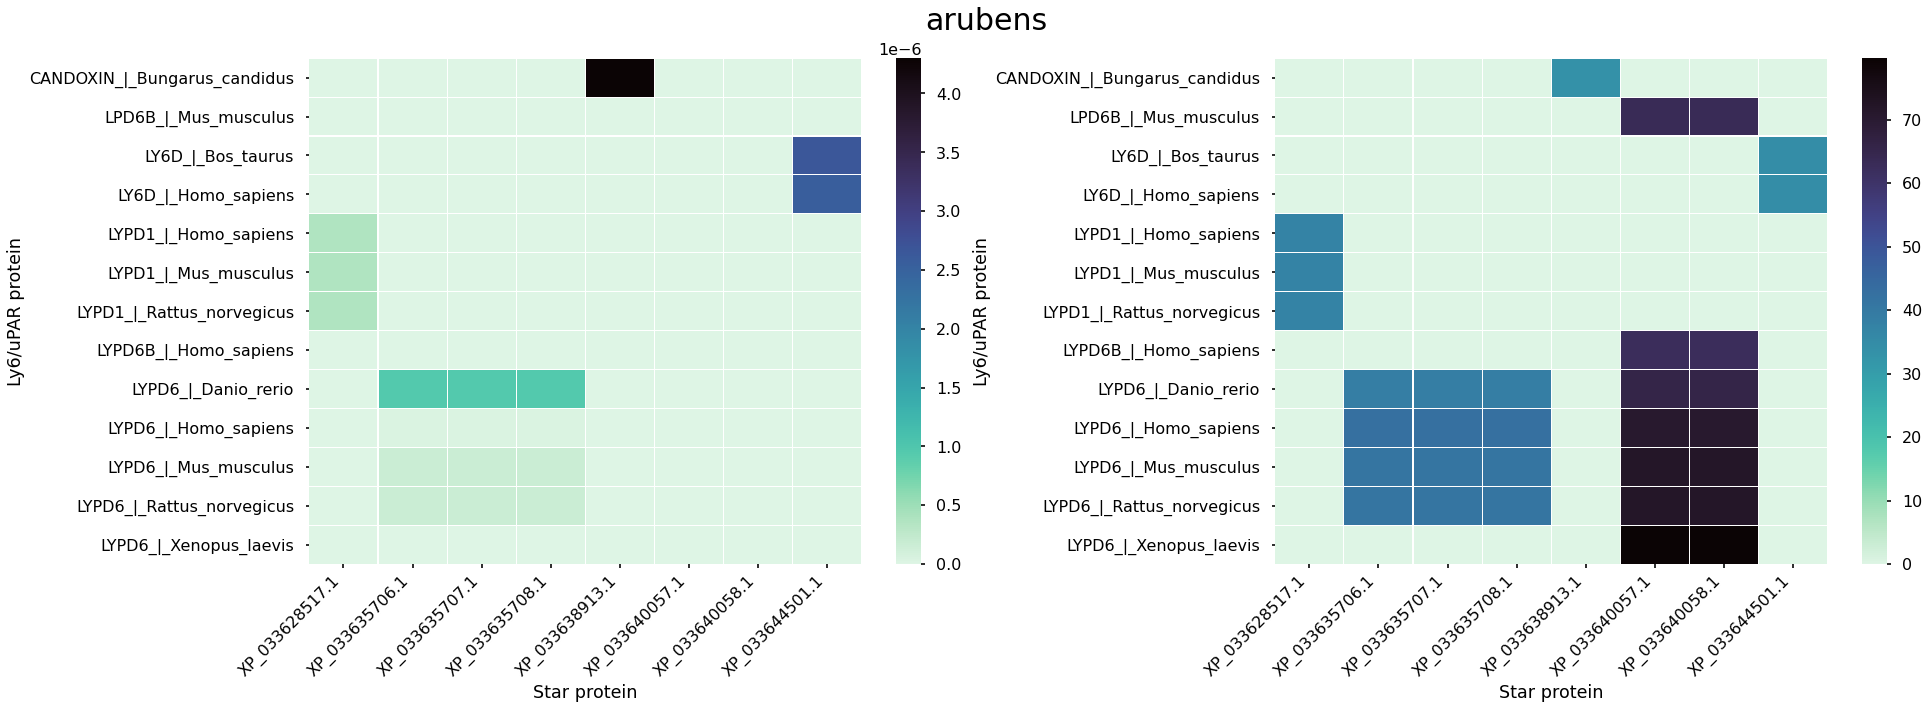

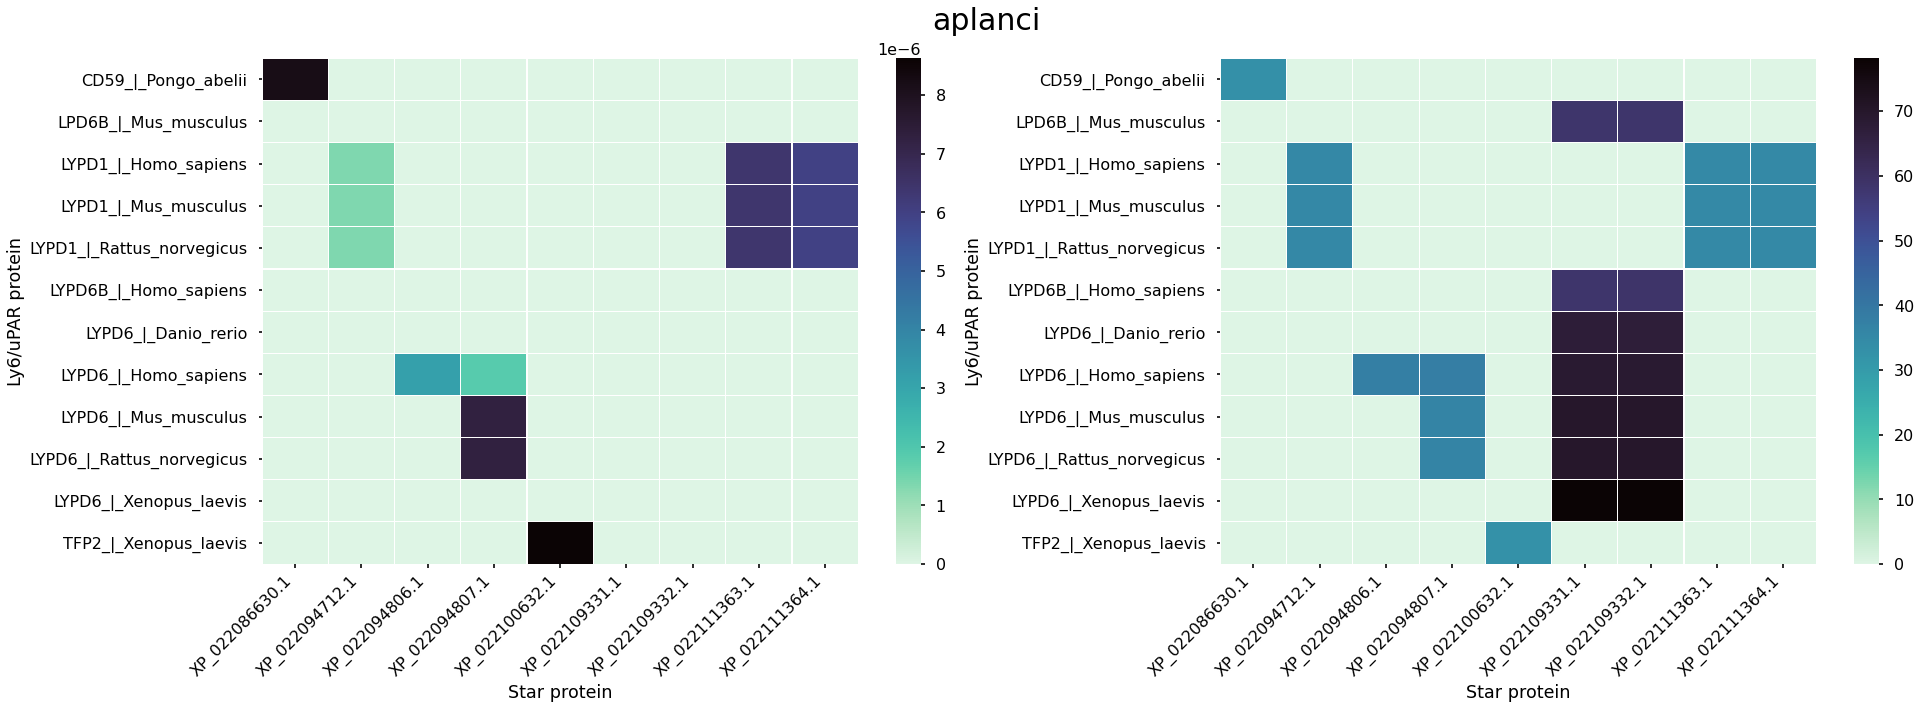

In [28]:
def print_heatmap(path):
    sp = 'Star protein'
    lp = 'Ly6/uPAR protein'
    ev = 'e-value'
    bs = 'bit score'
    df = pd.read_csv(path, sep='\t', header=None).rename(columns={
        0: sp,
        1: lp,
        10: ev,
        11: bs
    })
    kwargs = {'cmap': 'mako_r', 'linecolor': 'white', "linewidths": 0.1}
    fig, ax = plt.subplots(1, 2, figsize=(27.5, 10))
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=ev).fillna(0), ax=ax[0], **kwargs)
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=bs).fillna(0), ax=ax[1], **kwargs)
    for i in ax:
        i.set_xticklabels(i.get_xticklabels(), rotation = 45, ha="right", va='center_baseline')
    fig.suptitle(os.path.split(path)[-1].split('_')[0], fontsize=30)
    plt.tight_layout()
    plt.savefig(f"result/img/{path.split('/')[-1].rsplit('.', 1)[0]}.svg", facecolor='white', format='svg')
    plt.show()
print_heatmap('blast/arubens_blast_short.txt')
print_heatmap('blast/aplanci_blast_short.txt')

In [29]:
from biotite.sequence import ProteinSequence
import biotite.sequence.align as Align
from biotite.sequence import LetterAlphabet
import biotite.sequence.graphics as graphs
import matplotlib.pyplot as plt

In [30]:
def similarity(x: str, y: str, d: dict):
    res = [1 for i, j in enumerate(x) if d[j] == d[y[i]]]
    return f'{round(sum(res)/len(x), 2)}'

In [31]:
def get_aln(gene: str, org: str,star_blast: pd.DataFrame, df: pd.DataFrame):
    seq = pd.DataFrame(star_blast.loc[gene.replace(' ', '_') + '_|_' + org.replace(' ', '_')]).T
    ly6upar_ser = short.set_index('id').loc[df.loc[gene, 'hit ly6 protein']]
    if isinstance(ly6upar_ser, pd.Series):
        ly6upar_ser = pd.DataFrame(ly6upar_ser).T
    return pd.concat([ly6upar_ser, seq]).fillna('').reset_index().rename(columns={'index': 'id'})

In [32]:
color_map = """-=#ffffff
A=#7eff00
C=#ffe300
D=#ff0000
E=#ff0000
F=#7eff00
G=#ff00e4
H=#7eff00
I=#7eff00
K=#007bff
L=#7eff00
M=#7eff00
N=#ff00e4
P=#7eff00
Q=#ff00e4
R=#7eff00
S=#ff00e4
T=#ff00e4
V=#7eff00
W=#7eff00
X=#7eff00
Y=#ff00e4""".split('\n')
color_map = {i.split('=')[0]: i.split('=')[1] for i in color_map}
tmp = {}
for k, v in color_map.items():
    tmp[v] = tmp.get(v, []) + [k]
d = {a: res for (_, v), res in zip(tmp.items(), range(len(tmp))) for a in v}    

In [33]:
def get_pictures(star_name, organism):

    star_blast = read_blast(f'{star_name}_seq.csv', organism)
    df = pd.read_csv(f'blast/{star_name}_blast_short.txt', sep='\t', header=None)
    cols = [
        'star gene',
        'hit ly6 protein',
        'ident percent',
        'alignment length',
        'mismatch',
        'gapopen',
        'alignment start aa from star protein',
        'alignment end aa from star protein',
        'alignment start aa from ly6 protein',
        'alignment end aa from ly6 protein',
        'blast e-value',
        'blast bit score',
    ]
    df.columns = cols
    df = df.set_index(cols[0])
    star_genes = df.index.unique().tolist()
    star_genes
    for gene in star_genes:
        try:
            tmp = get_aln(gene, org=organism, star_blast=star_blast, df=df)
        except KeyError:
            print(gene, 'protein has duplicated domain')
            continue
        gene = gene.split('_|_')[0]
        sequence_dict = {k: ProteinSequence(v) for k, v in tmp.set_index('id').domain.to_dict().items()}

        headers = list(sequence_dict.keys())
        sequences = list(sequence_dict.values())

        # Perform a multiple sequence alignment
        matrix = pd.read_csv('matrix.txt', sep='\s+', skiprows=1, index_col=0)
        matrix = matrix.melt(ignore_index=False)

        alph1 = sequences[0].get_alphabet()
        alph2 = sequences[0].get_alphabet()
        matrix_dict = matrix.set_index('variable', append=True).value.to_dict()

        matrix = Align.SubstitutionMatrix(alph1, alph2, matrix_dict)

        alignment, order, _, _ = Align.align_multiple(sequences, matrix)

        # Order alignment according to guide tree
        alignment = alignment[:, order.tolist()]
        aln_seqs = alignment.get_gapped_sequences()

        ref_seq = aln_seqs[0]
        headers = [headers[i].replace('_', ' ') for i in order]
        headers = [name  + '    ' + similarity(ref_seq, aln_seqs[i], d) for i, name in enumerate(headers)]
        ref_head = headers[0]

        for k, v in zip(headers, aln_seqs):
            print(k, ':', similarity(ref_seq, v, d))
        fig, ax = plt.subplots(1, 1, figsize=(
            len(max(sequences, key=len)) / 3,
            len(sequences) / 2)
                              )
        graphs.plot_alignment_type_based(
            ax, alignment, labels=headers,
            symbols_per_line=len(alignment),
            label_size=13, symbol_size=12,
            color_scheme=list(map(color_map.get, sequences[0].get_alphabet()))
        )

        ax.set_aspect("equal")
    #     ax.set_title(gene, color="black")
        fig.tight_layout()
        fig.savefig(f'result/img/{star_name}_{gene}_alignment.svg', facecolor='white')
        plt.show()

XP 033628517.1 | Asterias rubens    1.0 : 1.0
LYPD1 | Rattus norvegicus    0.55 : 0.55
LYPD1 | Homo sapiens    0.55 : 0.55
LYPD1 | Mus musculus    0.55 : 0.55


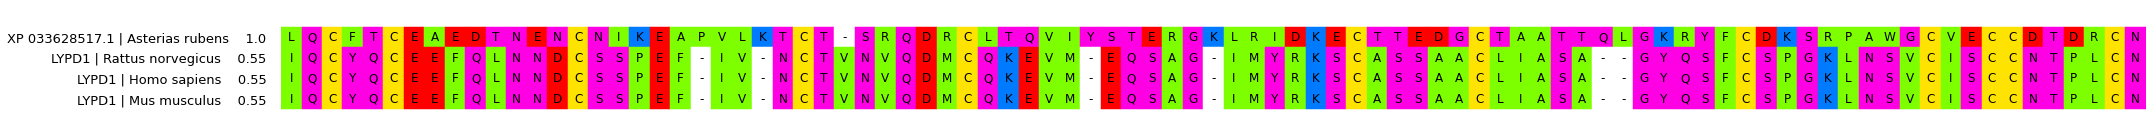

XP 033635706.1 | Asterias rubens    1.0 : 1.0
LYPD6 | Danio rerio    0.37 : 0.37
LYPD6 | Rattus norvegicus    0.38 : 0.38
LYPD6 | Mus musculus    0.38 : 0.38
LYPD6 | Homo sapiens    0.37 : 0.37


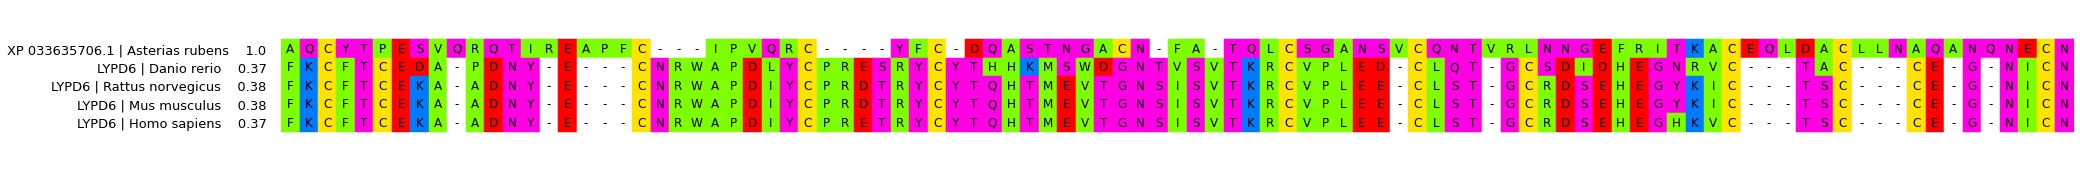

XP_033635707.1 protein has duplicated domain
XP_033635708.1 protein has duplicated domain
XP 033638913.1 | Asterias rubens    1.0 : 1.0
CANDOXIN | Bungarus candidus    0.45 : 0.45


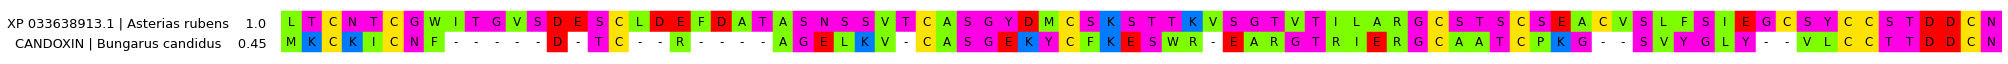

XP 033640057.1 | Asterias rubens    1.0 : 1.0
LYPD6B | Homo sapiens    0.58 : 0.58
LPD6B | Mus musculus    0.56 : 0.56
LYPD6 | Danio rerio    0.6 : 0.6
LYPD6 | Homo sapiens    0.65 : 0.65
LYPD6 | Rattus norvegicus    0.64 : 0.64
LYPD6 | Mus musculus    0.64 : 0.64
LYPD6 | Xenopus laevis    0.67 : 0.67


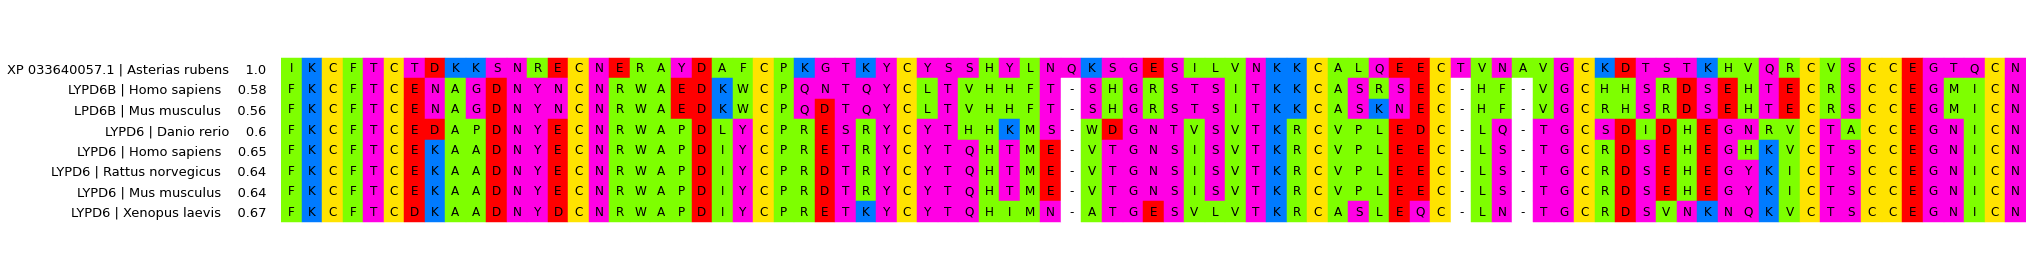

XP_033640058.1 protein has duplicated domain
XP 033644501.1 | Asterias rubens    1.0 : 1.0
LY6D | Bos taurus    0.4 : 0.4
LY6D | Homo sapiens    0.45 : 0.45


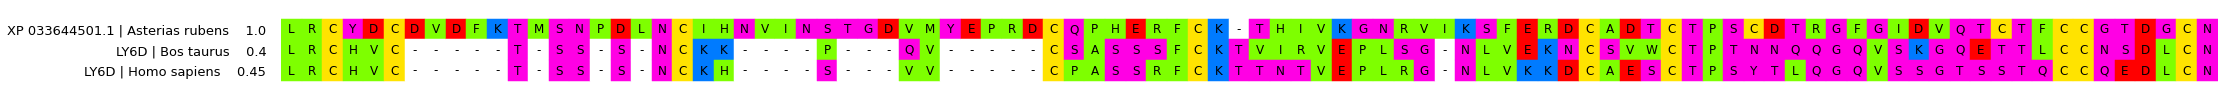

In [34]:
get_pictures('arubens', 'Asterias rubens')

XP 022086630.1 | Acanthaster planci    1.0 : 1.0
CD59 | Pongo abelii    0.44 : 0.44


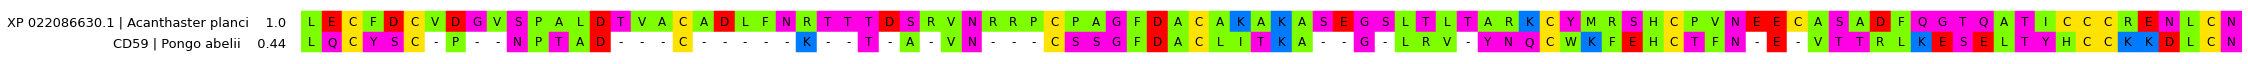

XP 022094712.1 | Acanthaster planci    1.0 : 1.0
LYPD1 | Rattus norvegicus    0.55 : 0.55
LYPD1 | Homo sapiens    0.55 : 0.55
LYPD1 | Mus musculus    0.55 : 0.55


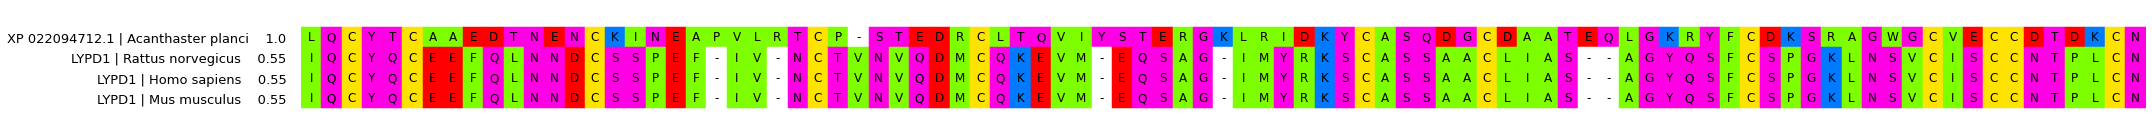

XP 022094807.1 | Acanthaster planci    1.0 : 1.0
LYPD6 | Rattus norvegicus    0.49 : 0.49
LYPD6 | Mus musculus    0.49 : 0.49
LYPD6 | Homo sapiens    0.48 : 0.48


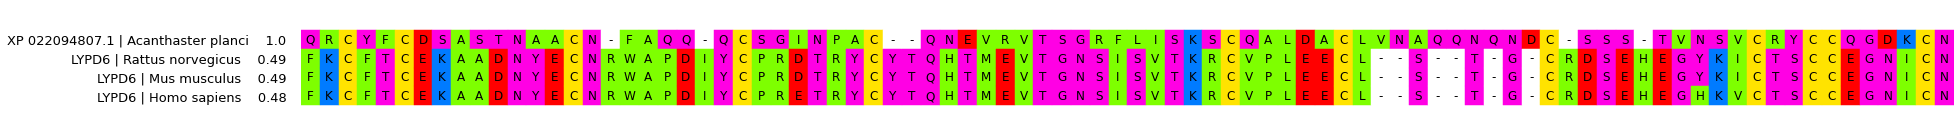

XP 022094806.1 | Acanthaster planci    1.0 : 1.0
LYPD6 | Homo sapiens    0.36 : 0.36


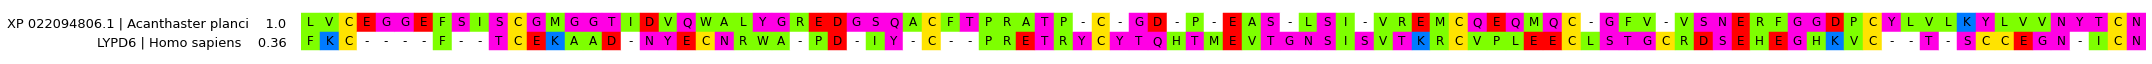

XP 022100632.1 | Acanthaster planci    1.0 : 1.0
TFP2 | Xenopus laevis    0.57 : 0.57


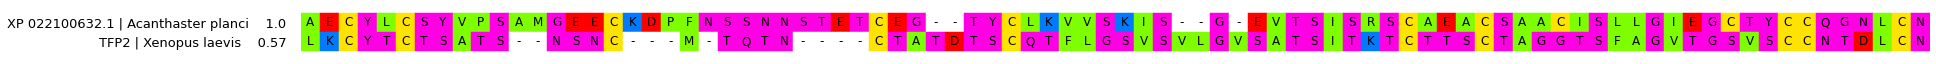

XP 022109332.1 | Acanthaster planci    1.0 : 1.0
LPD6B | Mus musculus    0.54 : 0.54
LYPD6B | Homo sapiens    0.55 : 0.55
LYPD6 | Danio rerio    0.61 : 0.61
LYPD6 | Homo sapiens    0.65 : 0.65
LYPD6 | Rattus norvegicus    0.64 : 0.64
LYPD6 | Mus musculus    0.64 : 0.64
LYPD6 | Xenopus laevis    0.67 : 0.67


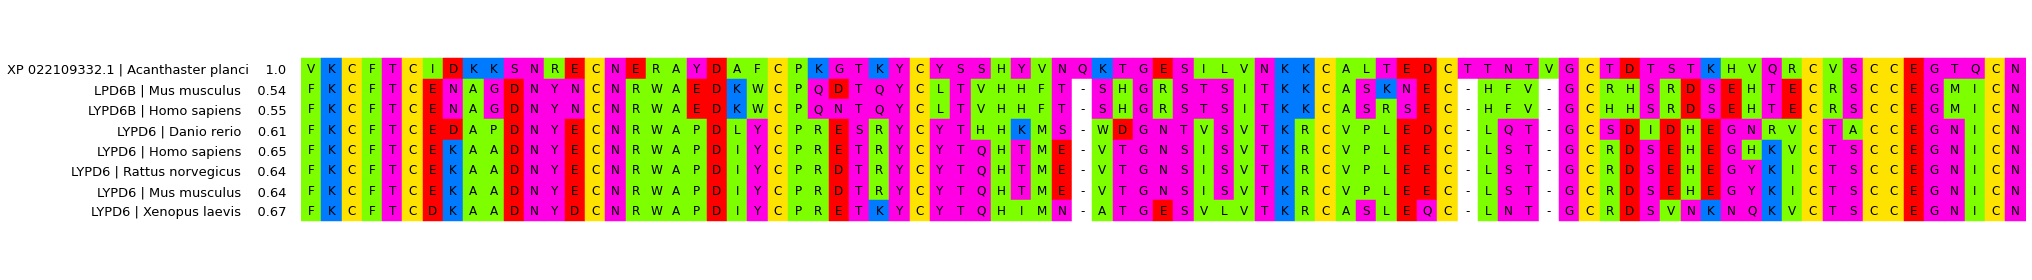

XP_022109331.1 protein has duplicated domain
XP 022111363.1 | Acanthaster planci    1.0 : 1.0
LYPD1 | Rattus norvegicus    0.57 : 0.57
LYPD1 | Homo sapiens    0.57 : 0.57
LYPD1 | Mus musculus    0.57 : 0.57


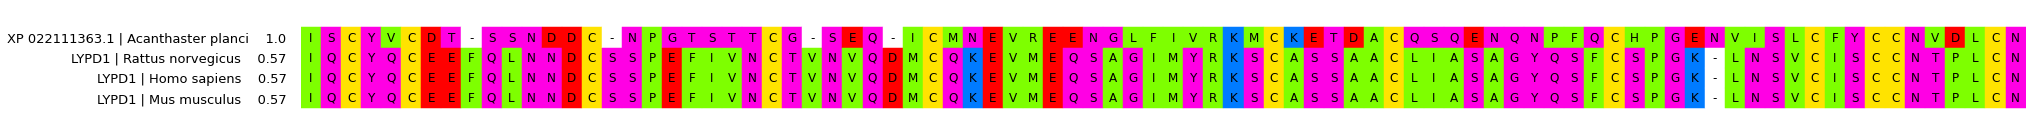

XP_022111364.1 protein has duplicated domain


In [35]:
get_pictures('aplanci', 'Acanthaster planci')